In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
cd '/gdrive/My Drive/Colab Notebooks/gene_gsp_classification/'

/gdrive/My Drive/Colab Notebooks/gene_gsp_classification


In [3]:
import numpy as np
import pandas as pd
import os
import copy
import seaborn as sn
from IPython.display import Image
from datetime import datetime
from pynvml import *
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm, trange
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset
writer = SummaryWriter()
from sklearn.utils import class_weight

from bokeh.io import output_file, show , output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,  LabelSet
from bokeh.palettes import Viridis256,all_palettes,BrBG, PiYG, RdGy, RdYlGn, YlGnBu, PuBuGn, Colorblind, Bokeh,Category20,Accent

In [4]:
ls nucleosome/

C_elegans.csv            final_melanogaster.csv      melanogaster_spect_sft/
C_elegans_spect/         final_melanogaster_dft.csv  models/
C_elegans_spect_dft/     final_melanogaster_sft.csv  sapiens.csv
C_elegans_spect_sft/     final_sapiens.csv           sapiens.gsheet
Data/                    final_sapiens_dft.csv       sapiens_spect/
data_creation.ipynb      final_sapiens_sft.csv       sapiens_spect_dft/
final_C_elegans.csv      melanogaster.csv            sapiens_spect_sft/
final_C_elegans_dft.csv  melanogaster_spect/         txt2data.py
final_C_elegans_sft.csv  melanogaster_spect_dft/


In [ ]:
#!zip -r nuc.zip nucleosome/C_elegans_spect_sft/ nucleosome/melanogaster_spect_sft/ nucleosome/sapiens_spect_sft/ -v
#!cp nucleosome/{final_melanogaster_sft.csv,final_C_elegans_sft.csv,final_sapiens_sft.csv} /content/nucleosome/

In [ ]:
!cp nuc.zip /content/
!unzip /content/nuc.zip -d  /content/
!cp nucleosome/{final_melanogaster_sft.csv,final_C_elegans_sft.csv,final_sapiens_sft.csv} /content/nucleosome/

In [11]:
!cp nucleosome/models -r /content/nucleosome/

In [12]:
cd /content/

/content


In [13]:
ls /content/nucleosome/

C_elegans_spect_sft/        final_sapiens_sft.csv    sapiens_spect_sft/
final_C_elegans_sft.csv     melanogaster_spect_sft/
final_melanogaster_sft.csv  models/


## Functions

In [14]:
def show_img(img, class_name):
    if torch.is_tensor(img):
        img=to_pil_image(img)
    print("class :",class_name)
    plt.imshow(img)

In [15]:
def get_class_names(y_data):
    y_class_names = []
    for i in range(len(y_data)):
        if(y_data[i]==0):
            y_class_names.append("inhibitor")
        elif (y_data[i]==1):
            y_class_names.append("forming")
    return y_class_names

In [16]:
def show_images(images, labels, preds,class_names):
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(images):
        plt.subplot(1, 4, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}',fontsize = 40)
        plt.ylabel(f'{class_names[int(preds[i])]}', color=col,fontsize = 40)
    plt.tight_layout()
    plt.show()

In [17]:
def show_preds(model,loader,image_fun,loss_fn,class_names):
    model.eval() 
    print("test set evaluation")
    with torch.no_grad():
        accuracy = 0
        metric = 0
        pred = []
        train = []
        for test_step, (images, labels, gene_type) in enumerate(tqdm(loader)):

          x_train = change_device(images)
          y_train = change_device(labels)
          y_pred = model(x_train)

          loss = loss_fn(y_pred,y_train)
          with torch.no_grad():
            
            for i in range(len(y_train)):
              if(int(torch.argmax(y_pred[i]).item())==int(y_train[i].item())):
                metric+=1 
              pred.append(torch.argmax(y_pred[i]).item())   
        accuracy = metric/len(loader.dataset)
        print(f' Accuracy: {accuracy:.4f}')
        image_fun(images[:4], y_train.cpu()[:4], pred[:4],class_names)
      
    return pred

In [18]:
def gene_tag(gene):
  gene_seq = []
  for i in range(len(gene)):
    if (gene[i]=="T"):
      gene_seq.append(0)
    elif (gene[i]=="G"):
      gene_seq.append(3)
    elif (gene[i]=="C"):
      gene_seq.append(1)
    elif (gene[i]=="A"):
      gene_seq.append(2)
  return gene_seq

In [19]:
ham = signal.get_window('hamming', 25)
def get_spectogram(gene_seq,path):
  f, t, Sxx = signal.spectrogram(np.array(gene_seq), fs=1, window = ham, mode = 'magnitude')
  #plt.pcolormesh(t, f, Sxx,vmin = np.min(Sxx), vmax = np.max(Sxx))
  plt.pcolormesh(t, f, Sxx)
  plt.ylabel('Frequency [Hz]')
  plt.xlabel("Nucleotide Positions")
  plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
  plt.axis('tight')
  plt.axis('off')
  plt.savefig(path+'.png', dpi=300, frameon='false')

In [20]:
def change_device(input):
  if torch.cuda.is_available():
    return input.cuda()
  else:
    return input

In [21]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [22]:
def cudaalloc():
  nvmlInit()
  h = nvmlDeviceGetHandleByIndex(0)
  info = nvmlDeviceGetMemoryInfo(h)
  print(f'total    : {info.total}')
  print(f'free     : {info.free}')
  print(f'used     : {info.used}')

In [23]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [24]:
def loss_batch(loss_func, output, target, opt=None): 
     
    loss = loss_func(change_device(output), change_device(target))
    with torch.no_grad():
        metric = 0
        for i in range(len(target)):
            if(int(torch.argmax(output[i]).item())==int(target[i].item())):
                metric+=1      
                
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric

In [25]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl)
    total_data = len(dataset_dl.dataset)
    count=0;
    for xb, yb, gene_type in tqdm(dataset_dl):
        xb=change_device(xb)
        yb=change_device(yb)
        
        
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        count+=1;
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break
    
    loss=running_loss/float(len_data)
    
    metric=running_metric/float(total_data)
    
    return loss, metric

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        writer.add_scalar("Loss/train", train_loss, epoch)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        writer.add_scalar("Loss/val", val_loss, epoch)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
        print(train_metric)    
        print("train loss: %.6f, accuracy: %.2f" %(train_loss,train_metric))
        print("val loss: %.6f, accuracu: %.2f" %(val_loss,val_metric))
        print("-"*10) 
        

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [28]:
def print_multi_confusion_matrix(actual_class, pred_class,target_names):
    df_array  = confusion_matrix(actual_class, pred_class)
    df_cm = pd.DataFrame(df_array, index = [i for i in ["T_" + x for x in target_names]],
                      columns = [i for i in ["P_" + x for x in target_names]])
    plt.figure(figsize = (7,7))
    plt.title("Confusion Matrix")
    plt.xlabel('Target Nucleosome')
    plt.ylabel('Predicted Nuclesome')
    sn.heatmap(df_cm, annot=True)
    sn.set(font_scale=1) 
    print(classification_report(actual_class, pred_class, target_names=target_names))

In [29]:
def print_activation_maps(model, img, labels, loss_func, y_pred, class_names):

  l = 1
  for r in range(0,4):
    xb_out = change_device(xb)
    output = model(xb_out[r].unsqueeze(0))
    target = np.argmax(output.cpu().detach().numpy())
    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
    one_hot_output[0][target] = 1
    output.backward(gradient = change_device(one_hot_output), retain_graph=True)
    gradients = model.get_activations_gradient()

    print(f' Actual class: {class_names[int(labels[r].cpu())]} predicted class : {class_names[int(torch.argmax(one_hot_output).item())]}')
    plt.figure(figsize=(20, 20))
    plt.subplot(6, 3, l , xticks=[], yticks=[])
    l = l+1
    

    image = np.asarray(img[r]).transpose(1,2,0)
    image = np.clip(image, 0., 1.)
    image_gray = rgb2gray(image)
    plt.imshow(image)

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(change_device(img)).cpu().detach()
    for i in range(activations.shape[1]):
      activations[:, i, :, :] *= pooled_gradients[i].cpu()
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.subplot(6, 3, l, xticks=[], yticks=[])
    plt.imshow(heatmap[r].squeeze())

    l = l+1
  
    heatmaps = cv2.resize(heatmap[r].numpy(), (image.shape[1], image.shape[0]))
    heatmaps = np.uint8(255 * heatmaps)
    superimposed_img = heatmaps*image_gray
  
    plt.subplot(6, 3, l, xticks=[], yticks=[])
    plt.imshow(superimposed_img)
    plt.show()
    l = l+1

## Data Loading

In [30]:
class specto_dataset(Dataset):
    def __init__(self, dataframe, transform=None):      

        self.SpecPath = dataframe['path'].values
        self.ClassName = dataframe['class'].values
        self.gene_type = dataframe['file_type'].values
        self.transform = transform
    
    def __len__(self):
        return len(self.SpecPath)
      
    def __getitem__(self, idx):
        path2img = self.SpecPath[idx]
        class_name = self.ClassName[idx]
        image = Image.open(path2img).convert('RGB')
        gene_type = self.gene_type[idx]
        image= np.array(image)    

        if self.transform:
            image = self.transform(image)       
          #the to_tensor function normalizes the values 
          #by diving them to 255. As such, we scaled back the 
          #mask values to the range of [0, 1] by multiplying it by 255.             
        return image, class_name, gene_type

In [31]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

In [ ]:
#melanogaster
#sapiens
data1 = pd.read_csv('nucleosome/final_melanogaster_sft.csv')

file_type = []
for i in range(len(data1)):
  file_type.append('melanogaster')
data1['file_type'] = file_type

data2 = pd.read_csv('nucleosome/final_sapiens_sft.csv')

file_type = []
for i in range(len(data2)):
  file_type.append('sapiens')
data2['file_type'] = file_type

data3 = pd.read_csv('nucleosome/final_C_elegans_sft.csv')

file_type = []
for i in range(len(data3)):
  file_type.append('C_elegans')
data3['file_type'] = file_type

data_new = pd.concat([data1,data2,data3])
data_new.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)
data_new = data_new.reset_index(drop=True)
class_name = []
for i in range(len(data_new)):
  if(data_new['label'][i]=='Nucleosome_Forming'):
    class_name.append(1)
  elif(data_new['label'][i]=='Nucleosome_Inhibiting'):
    class_name.append(0)
data_new['class'] = class_name


In [ ]:
data_new.tail()

,gene_sequences,label,path,file_type,class
15493,TGTGATTTTTAAATTTTTATTTTTTTCCAGTTTTTCGAATTTTTCA...,Nucleosome_Inhibiting,nucleosome/C_elegans_spect_sft/inhib_5170.png,C_elegans,0
15494,TGTGCGCCCAGTTTTCCGACGGCGGTTTTGCGACACGCAAAACGGA...,Nucleosome_Inhibiting,nucleosome/C_elegans_spect_sft/inhib_5171.png,C_elegans,0
15495,AAAATGACTCCGTGTAACTCTACAAAAAGATGGTGTATTGAAATAA...,Nucleosome_Inhibiting,nucleosome/C_elegans_spect_sft/inhib_5172.png,C_elegans,0
15496,GAAATAGAAATTTAAAATTATTAATGTCTGAGCTCCTGTCAATTTT...,Nucleosome_Inhibiting,nucleosome/C_elegans_spect_sft/inhib_5173.png,C_elegans,0
15497,AAAATTTTAATAAATAAATGAATAAATCATTTCGAAAACCAAGCCC...,Nucleosome_Inhibiting,nucleosome/C_elegans_spect_sft/inhib_5174.png,C_elegans,0


In [ ]:
print(data_new['file_type'].unique())

['melanogaster' 'sapiens' 'C_elegans']


In [ ]:
X_data = data_new['gene_sequences'].values
y_data = data_new['class'].values
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(test_size=.10, n_splits=5, random_state = 42)
train_inds, test_inds = next(skf.split(X_data, data_new['file_type'].values))

X_traintest_dataframe = data_new.iloc[train_inds].reset_index(drop=True)
X_test_dataframe = data_new.iloc[test_inds].reset_index(drop=True)

skf = StratifiedShuffleSplit(test_size=.10, n_splits=5, random_state = 42)
train_inds, test_inds = next(skf.split(X_traintest_dataframe['gene_sequences'].values, 
                                       X_traintest_dataframe['file_type'].values))

X_train_dataframe = X_traintest_dataframe.iloc[train_inds].reset_index(drop=True)
X_val_dataframe = X_traintest_dataframe.iloc[test_inds].reset_index(drop=True)

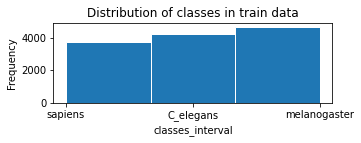

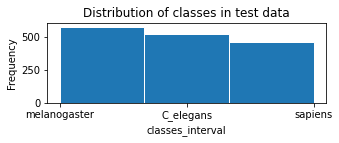

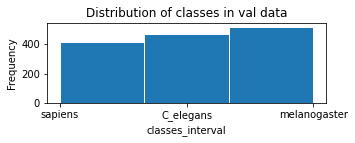

In [ ]:
plt.figure(figsize=(5,5))

plt.subplot(3,1,1)
plt.title('Distribution of classes in train data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
n,bins,patches = plt.hist(X_train_dataframe['file_type'],bins=3,edgecolor='white')

plt.figure(figsize=(5,5))
plt.subplot(3,1,2)
plt.title('Distribution of classes in test data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
plt.hist(X_test_dataframe['file_type'],bins=3,edgecolor='white')
plt.show() 

plt.figure(figsize=(5,5))
plt.subplot(3,1,3)
plt.title('Distribution of classes in val data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
plt.hist(X_val_dataframe['file_type'],bins=3,edgecolor='white')
plt.show() 

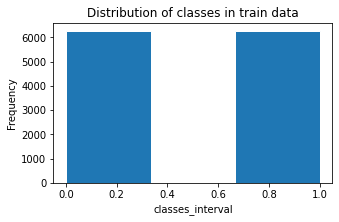

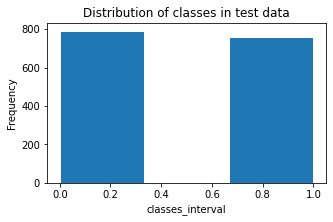

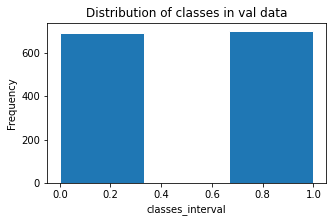

In [ ]:
plt.figure(figsize=(5,10))

plt.subplot(3,1,1)
plt.title('Distribution of classes in train data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
n,bins,patches = plt.hist(X_train_dataframe['class'],bins=3,edgecolor='white')

plt.figure(figsize=(5,10))
plt.subplot(3,1,2)
plt.title('Distribution of classes in test data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
plt.hist(X_test_dataframe['class'],bins=3,edgecolor='white')
plt.show() 

plt.figure(figsize=(5,10))
plt.subplot(3,1,3)
plt.title('Distribution of classes in val data')
plt.xlabel('classes_interval')
plt.ylabel('Frequency')
plt.hist(X_val_dataframe['class'],bins=3,edgecolor='white')
plt.show() 

In [ ]:
train_ds=specto_dataset(X_train_dataframe,transform)
val_ds=specto_dataset(X_val_dataframe,transform)
test_ds=specto_dataset(X_test_dataframe,transform)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

12553
1395
1550


In [ ]:
img,class_name, gene_type = train_ds[2]
print(img.shape, img.type(),torch.max(img),class_name, gene_type)

torch.Size([3, 224, 224]) torch.FloatTensor tensor(1.) 0 melanogaster


In [ ]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size= batch_size, shuffle=False)
val_dl = DataLoader(val_ds, batch_size= batch_size, shuffle=False)

class : 0


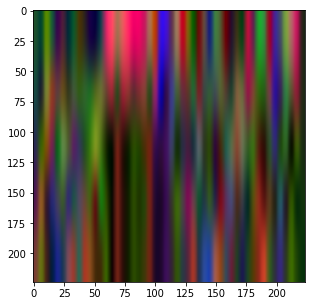

In [ ]:
plt.figure(figsize=(5,5))
for img,class_name,gene_type in train_ds:
    show_img(img, class_name)
    break

class : 0


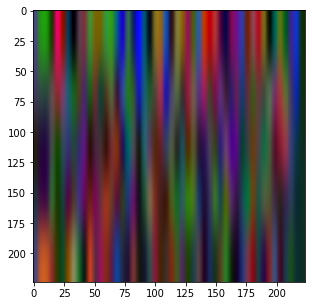

In [ ]:
plt.figure(figsize=(5,5))
for img,class_name,gene_type in val_ds:
    show_img(img, class_name) 
    break

In [ ]:
for img_b, class_name,gene_type in test_dl:
    print(img_b.shape,class_name, gene_type)
    break

torch.Size([32, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 1]) ('melanogaster', 'melanogaster', 'melanogaster', 'melanogaster', 'C_elegans', 'C_elegans', 'C_elegans', 'melanogaster', 'sapiens', 'melanogaster', 'C_elegans', 'sapiens', 'sapiens', 'melanogaster', 'C_elegans', 'C_elegans', 'melanogaster', 'sapiens', 'melanogaster', 'melanogaster', 'sapiens', 'C_elegans', 'melanogaster', 'sapiens', 'C_elegans', 'C_elegans', 'sapiens', 'sapiens', 'melanogaster', 'melanogaster', 'C_elegans', 'melanogaster')


In [ ]:
for img_b, class_name,gene_type in train_dl:
    images,labels = img_b, class_name
    print(img_b.shape,class_name, gene_type)
    break

torch.Size([32, 3, 224, 224]) tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 0]) ('sapiens', 'melanogaster', 'sapiens', 'melanogaster', 'C_elegans', 'sapiens', 'melanogaster', 'sapiens', 'melanogaster', 'sapiens', 'melanogaster', 'C_elegans', 'C_elegans', 'sapiens', 'C_elegans', 'melanogaster', 'melanogaster', 'sapiens', 'melanogaster', 'C_elegans', 'sapiens', 'melanogaster', 'melanogaster', 'C_elegans', 'melanogaster', 'sapiens', 'melanogaster', 'sapiens', 'sapiens', 'sapiens', 'melanogaster', 'melanogaster')


In [ ]:
for img_b, class_name,gene_type in val_dl:
    print(img_b.shape,class_name, gene_type)
    break

torch.Size([32, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0]) ('sapiens', 'C_elegans', 'sapiens', 'melanogaster', 'melanogaster', 'C_elegans', 'C_elegans', 'melanogaster', 'melanogaster', 'sapiens', 'melanogaster', 'C_elegans', 'C_elegans', 'melanogaster', 'melanogaster', 'C_elegans', 'melanogaster', 'melanogaster', 'melanogaster', 'melanogaster', 'melanogaster', 'sapiens', 'C_elegans', 'C_elegans', 'sapiens', 'C_elegans', 'melanogaster', 'sapiens', 'sapiens', 'sapiens', 'C_elegans', 'melanogaster')


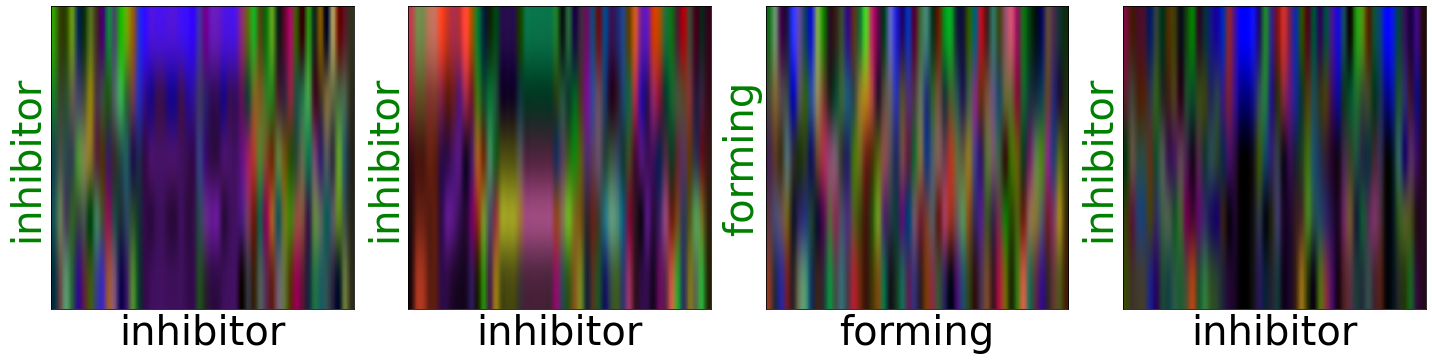

In [ ]:
class_names = {}
class_names[1] = 'forming'
class_names[0] = 'inhibitor'
show_images(images[:4],labels[:4],labels[:4],class_names)

## Model Implementation

In [ ]:
densenet121 = torchvision.models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, model):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.averagepool = nn.AdaptiveAvgPool2d(1)
        
        # get the classifier of the vgg19
        self.classifier = torch.nn.Linear(in_features=1024, out_features=2)
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        if x.requires_grad:
          h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.averagepool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
model = change_device(DenseNet(densenet121))

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters and total memory usage is {count_parameters(model)*(4/(2**20)*3)} mb')

The model has 7,980,906 trainable parameters and total memory usage is 91.33422088623047 mb


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',classes = [0,1],y = data_new['class'].values)
print(class_weights)

[0.99883991 1.00116279]


In [ ]:
opt = optim.AdamW(model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.1, patience=10,verbose=1)
loss_func = torch.nn.CrossEntropyLoss(weight = change_device(torch.tensor(class_weights)).float())
current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [ ]:
cudaalloc()

total    : 17071734784
free     : 15845818368
used     : 1225916416


In [ ]:
root = 'nucleosome/'

In [ ]:
ls

nucleosome/  nuc.zip  sample_data/


In [ ]:
path2models= root + "models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 50,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+ "sft_all" + datetime.now().strftime('%M:%S_') + "weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Copied best model weights!
0.7488249820759978
train loss: 0.519973, accuracy: 0.75
val loss: 0.444803, accuracu: 0.80
----------
Epoch 1/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Copied best model weights!
0.7936748187684219
train loss: 0.452149, accuracy: 0.79
val loss: 0.444215, accuracu: 0.80
----------
Epoch 2/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8162192304628376
train loss: 0.405305, accuracy: 0.82
val loss: 0.464768, accuracu: 0.79
----------
Epoch 3/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8401975623356966
train loss: 0.364693, accuracy: 0.84
val loss: 0.461336, accuracu: 0.79
----------
Epoch 4/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8695929259937863
train loss: 0.307814, accuracy: 0.87
val loss: 0.546656, accuracu: 0.81
----------
Epoch 5/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8932526089381024
train loss: 0.257677, accuracy: 0.89
val loss: 0.547598, accuracu: 0.78
----------
Epoch 6/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9146817493826177
train loss: 0.205248, accuracy: 0.91
val loss: 0.632777, accuracu: 0.76
----------
Epoch 7/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9365888632199474
train loss: 0.158402, accuracy: 0.94
val loss: 0.792669, accuracu: 0.71
----------
Epoch 8/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.946068668844101
train loss: 0.135680, accuracy: 0.95
val loss: 0.719006, accuracu: 0.79
----------
Epoch 9/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9597705727714491
train loss: 0.107041, accuracy: 0.96
val loss: 0.775049, accuracu: 0.77
----------
Epoch 10/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9602485461642635
train loss: 0.103617, accuracy: 0.96
val loss: 0.930711, accuracu: 0.77
----------
Epoch 11/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9659045646459014
train loss: 0.089909, accuracy: 0.97
val loss: 0.816382, accuracu: 0.76
----------
Epoch 12/49, current lr=0.0003


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch    13: reducing learning rate of group 0 to 3.0000e-05.
Loading best model weights!
0.9698876762526886
train loss: 0.080947, accuracy: 0.97
val loss: 0.811050, accuracu: 0.80
----------
Epoch 13/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8738946865291165
train loss: 0.301271, accuracy: 0.87
val loss: 0.470814, accuracu: 0.80
----------
Epoch 14/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9347566318808253
train loss: 0.168498, accuracy: 0.93
val loss: 0.597989, accuracu: 0.79
----------
Epoch 15/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9821556600015933
train loss: 0.059032, accuracy: 0.98
val loss: 0.782172, accuracu: 0.78
----------
Epoch 16/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9932287102684617
train loss: 0.025775, accuracy: 0.99
val loss: 0.943787, accuracu: 0.79
----------
Epoch 17/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9945829682147693
train loss: 0.018360, accuracy: 0.99
val loss: 0.997764, accuracu: 0.78
----------
Epoch 18/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9943439815183621
train loss: 0.017498, accuracy: 0.99
val loss: 1.052399, accuracu: 0.78
----------
Epoch 19/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9923524257149685
train loss: 0.020608, accuracy: 0.99
val loss: 1.106931, accuracu: 0.79
----------
Epoch 20/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9893252608938102
train loss: 0.028432, accuracy: 0.99
val loss: 1.097957, accuracu: 0.79
----------
Epoch 21/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9938660081255477
train loss: 0.017306, accuracy: 0.99
val loss: 1.226638, accuracu: 0.78
----------
Epoch 22/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9954592527682625
train loss: 0.013507, accuracy: 1.00
val loss: 1.127246, accuracu: 0.79
----------
Epoch 23/49, current lr=2.9999999999999997e-05


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch    24: reducing learning rate of group 0 to 3.0000e-06.
Loading best model weights!
0.9975304708037919
train loss: 0.008852, accuracy: 1.00
val loss: 1.195388, accuracu: 0.79
----------
Epoch 24/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Copied best model weights!
0.8527045327810086
train loss: 0.345996, accuracy: 0.85
val loss: 0.425871, accuracu: 0.81
----------
Epoch 25/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8644945431370987
train loss: 0.326293, accuracy: 0.86
val loss: 0.428424, accuracu: 0.81
----------
Epoch 26/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.869991237154465
train loss: 0.309912, accuracy: 0.87
val loss: 0.428741, accuracu: 0.82
----------
Epoch 27/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8801083406357046
train loss: 0.293726, accuracy: 0.88
val loss: 0.431148, accuracu: 0.81
----------
Epoch 28/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8878355771528719
train loss: 0.274177, accuracy: 0.89
val loss: 0.439707, accuracu: 0.82
----------
Epoch 29/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8961204492949892
train loss: 0.259959, accuracy: 0.90
val loss: 0.455735, accuracu: 0.81
----------
Epoch 30/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9082291085796224
train loss: 0.238001, accuracy: 0.91
val loss: 0.457802, accuracu: 0.81
----------
Epoch 31/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9164343184896041
train loss: 0.217458, accuracy: 0.92
val loss: 0.468830, accuracu: 0.81
----------
Epoch 32/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.925197164024536
train loss: 0.197145, accuracy: 0.93
val loss: 0.483389, accuracu: 0.81
----------
Epoch 33/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.931410818131124
train loss: 0.181400, accuracy: 0.93
val loss: 0.505410, accuracu: 0.80
----------
Epoch 34/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.9417669083087709
train loss: 0.157872, accuracy: 0.94
val loss: 0.523992, accuracu: 0.80
----------
Epoch 35/49, current lr=3e-06


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Epoch    36: reducing learning rate of group 0 to 3.0000e-07.
Loading best model weights!
0.9475025890225444
train loss: 0.142786, accuracy: 0.95
val loss: 0.545045, accuracu: 0.79
----------
Epoch 36/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Copied best model weights!
0.8621843384051621
train loss: 0.329704, accuracy: 0.86
val loss: 0.425495, accuracu: 0.81
----------
Epoch 37/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8615470405480762
train loss: 0.331127, accuracy: 0.86
val loss: 0.430293, accuracu: 0.81
----------
Epoch 38/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8609894049231259
train loss: 0.329539, accuracy: 0.86
val loss: 0.432017, accuracu: 0.81
----------
Epoch 39/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8648131920656417
train loss: 0.324338, accuracy: 0.86
val loss: 0.426126, accuracu: 0.81
----------
Epoch 40/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Copied best model weights!
0.8677606946546642
train loss: 0.322625, accuracy: 0.87
val loss: 0.424480, accuracu: 0.82
----------
Epoch 41/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Copied best model weights!
0.8693539392973791
train loss: 0.322310, accuracy: 0.87
val loss: 0.424434, accuracu: 0.81
----------
Epoch 42/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8691946148331077
train loss: 0.316970, accuracy: 0.87
val loss: 0.428379, accuracu: 0.81
----------
Epoch 43/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8660081255476778
train loss: 0.319965, accuracy: 0.87
val loss: 0.425986, accuracu: 0.82
----------
Epoch 44/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8686369792081574
train loss: 0.315394, accuracy: 0.87
val loss: 0.430854, accuracu: 0.82
----------
Epoch 45/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8711861706365013
train loss: 0.311223, accuracy: 0.87
val loss: 0.426908, accuracu: 0.81
----------
Epoch 46/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8724607663506732
train loss: 0.313568, accuracy: 0.87
val loss: 0.426672, accuracu: 0.81
----------
Epoch 47/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8742929976897953
train loss: 0.305665, accuracy: 0.87
val loss: 0.430897, accuracu: 0.81
----------
Epoch 48/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8726200908149446
train loss: 0.306271, accuracy: 0.87
val loss: 0.429105, accuracu: 0.81
----------
Epoch 49/49, current lr=3.0000000000000004e-07


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

0.8755675934039672
train loss: 0.301976, accuracy: 0.88
val loss: 0.428936, accuracu: 0.81
----------


In [ ]:
ls /content/nucleosome/models/

ls: cannot access '/content/nucleosome/models/': No such file or directory


In [ ]:
cp /content/nucleosome/models/

In [ ]:
from bokeh.plotting import figure, show

# prepare some data
x = np.arange(0,len(loss_hist['train'])) 
y1 = loss_hist['train']
y2 = loss_hist['val']

# create a new plot with a title and axis labels
p = figure(title="Loss function of train and val", x_axis_label="x", y_axis_label="y",plot_width=1000, plot_height=400,align="center")
p.title.align = "center"
# add a line renderer with legend and line thickness
p.line(x, y1, legend_label="Train", line_width=2)
p.line(x, y2, legend_label="val", line_color="red", line_width=2)
output_notebook()
# show the results
show(p)

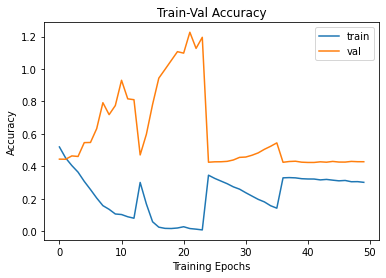

In [ ]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
x = np.arange(0,len(loss_hist['train'])) 
y1 = loss_hist['train']
y2 = loss_hist['val']
plt.plot(x,y1,label="train")
plt.plot(x,y2,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
from bokeh.plotting import figure, show

# prepare some data
x = np.arange(0,len(metric_hist['train'])) 
y1 = metric_hist['train']
y2 = metric_hist['val']

# create a new plot with a title and axis labels
p = figure(title="Accuracy of train and val", x_axis_label="x", y_axis_label="y",plot_width=1000, plot_height=500,align="center")
p.title.align = "center"
# add a line renderer with legend and line thickness
p.line(x, y1, legend_label="Train", line_width=2)
p.line(x, y2, legend_label="val", line_color="red", line_width=2)
output_notebook()
# show the results
show(p)

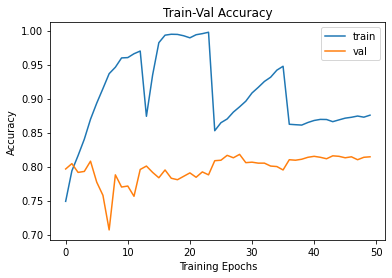

In [ ]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
x = np.arange(0,len(metric_hist['train'])) 
y1 = metric_hist['train']
y2 = metric_hist['val']
plt.plot(x,y1,label="train")
plt.plot(x,y2,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

test set evaluation


  0%|          | 0/49 [00:00<?, ?it/s]

 Accuracy: 0.8026


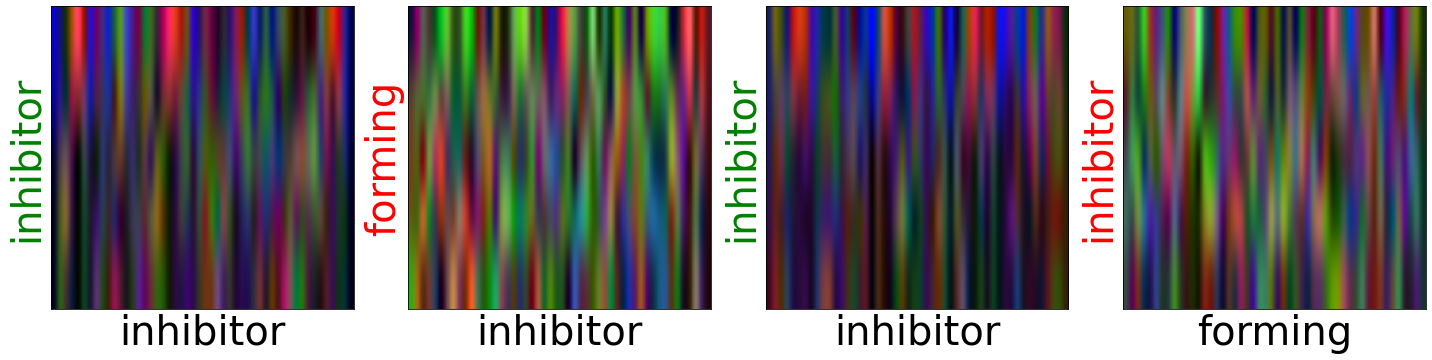

In [ ]:
pred = show_preds(model,test_dl,show_images,loss_func,class_names)

In [ ]:
#megalanomase accuracy = 

In [ ]:
gene_type

('C_elegans',
 'sapiens',
 'C_elegans',
 'C_elegans',
 'sapiens',
 'melanogaster',
 'C_elegans',
 'melanogaster',
 'C_elegans',
 'C_elegans',
 'C_elegans',
 'melanogaster',
 'C_elegans',
 'sapiens')

In [ ]:
model.eval() 
softmax = nn.Softmax(dim=0)
loss_func = torch.nn.CrossEntropyLoss(weight = change_device(torch.tensor(class_weights)).float())
with torch.no_grad():
  accuracy = 0
  metric = 0
  pred = []
  y_test_data = []
  pred_prob = []
  for test_step, (images, labels, gene_type) in enumerate(tqdm(test_dl)):
    

    x_test = change_device(images)
    y_test = change_device(labels)
    y_pred = model(x_test)
    
    loss = loss_func(y_pred,y_test)
    with torch.no_grad():
      
      for i in range(len(y_test)):
        if(gene_type[i]=='C_elegans' or gene_type[i]=='melanogaster'):
          continue
        if(int(torch.argmax(y_pred[i]).item())==int(y_test[i].item())):
          metric+=1 
        y_test_data.append(int(y_test[i].item()))
        
        pred.append(int(torch.argmax(y_pred[i]).item()))  
        pred_prob.append(np.array(softmax(y_pred[i]).cpu())) 
accuracy = metric/len(test_dl.dataset)
print(f' Accuracy: {accuracy:.4f}')

  0%|          | 0/49 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   inhibitor       0.87      0.76      0.81       235
     forming       0.77      0.88      0.83       222

    accuracy                           0.82       457
   macro avg       0.82      0.82      0.82       457
weighted avg       0.83      0.82      0.82       457



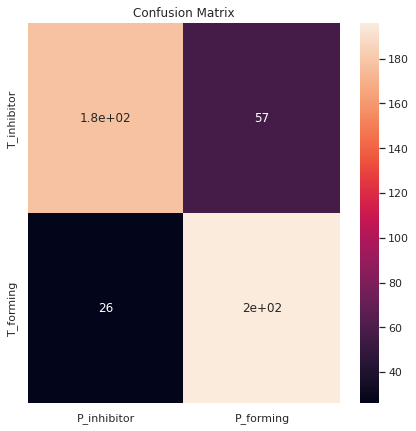

In [ ]:
actual_class = y_test_data
pred_class = pred
classnames = ['inhibitor', 'forming']
print_multi_confusion_matrix(actual_class,pred_class,target_names=classnames)
y_test_class_names = get_class_names(actual_class)
plt.show()

In [ ]:


def get_auc_curve(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    return fpr,tpr,threshold

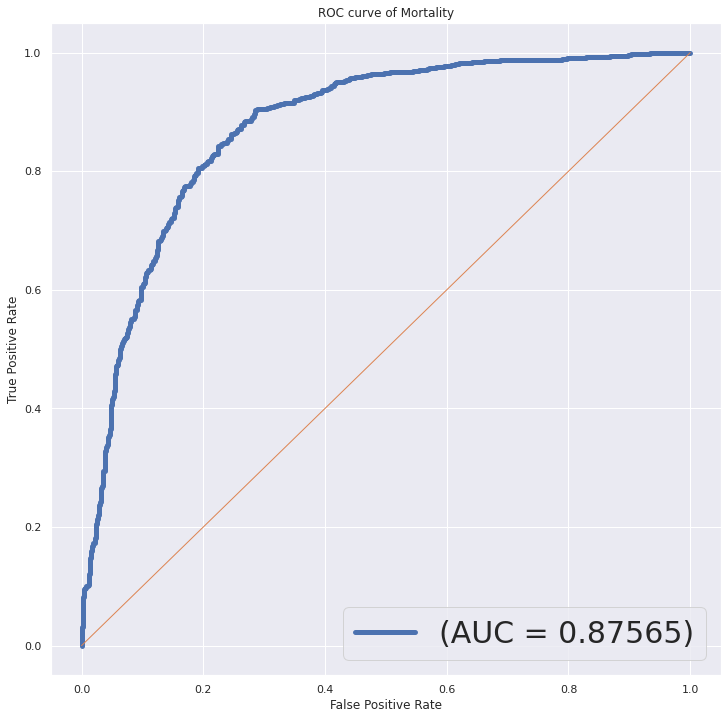

In [ ]:
class_names=["Alive","Dead"]
y_test_class_names = get_class_names(actual_class)
y_test_class = label_binarize(np.array(y_test_class_names),classes=classnames)
pred_prob = np.array(pred_prob)
y_test_class = np.array(y_test_class)
fpr, tpr,t = get_auc_curve(y_test_class,pred_prob[:, 1])
roc_auc = auc(fpr, tpr)
fig1 = plt.figure(figsize=[12,12])
plt.plot(fpr, tpr, lw=5, alpha=1, label='(AUC = %0.5f)' % (roc_auc))
plt.plot(np.linspace(0,1,len(fpr)), np.linspace(0,1,len(fpr)), lw=1, alpha=1 )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Mortality')
plt.legend(loc="lower right",prop={'size': 30})
plt.show()



In [ ]:

stop = 10
count= 0
for xb, yb,gb  in test_dl:
    if(count==stop):
        break
    count+=1
xb_out = change_device(xb)
model.eval()
output = model(xb_out[0].unsqueeze(0))
target = np.argmax(output.cpu().detach().numpy())
one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
one_hot_output[0][target] = 1
print(output , one_hot_output)


tensor([[ 1.7873, -1.7594]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([[1., 0.]])


 Actual class: inhibitor predicted class : inhibitor


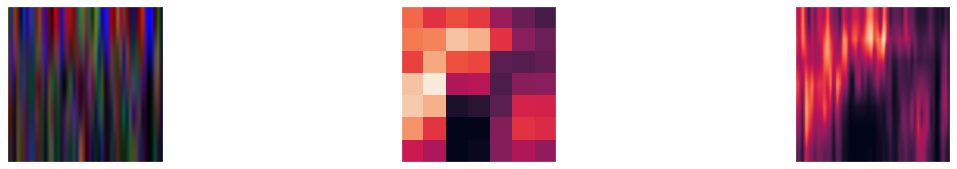

 Actual class: inhibitor predicted class : inhibitor


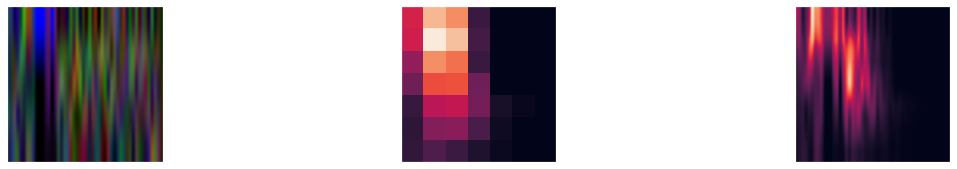

 Actual class: forming predicted class : forming


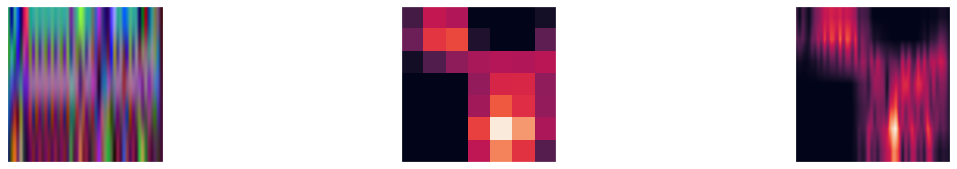

 Actual class: inhibitor predicted class : inhibitor


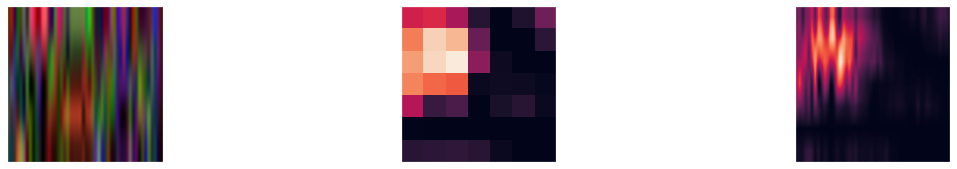

In [ ]:
import cv2
print_activation_maps(model, xb, yb, loss_func, output, classnames)